# Patent Citation Network

U.S. patent dataset is maintained by the [National Bureau of Economic Research](http://www.nber.org/). The data set spans 37 years (January 1, 1963 to December 30, 1999), and includes all the utility patents granted during that period, totaling 3,923,922 patents. The citation graph includes all citations made by patents granted between 1975 and 1999, totaling 16,522,438 citations. For the patents dataset there are 1,803,511 nodes for which we have no information about their citations (we only have the in-links).

The data was originally released by [NBER](http://www.nber.org/patents/). The dataset can be found at this link: [Stanford Patent Citation Network](https://snap.stanford.edu/data/cit-Patents.html)

## Import Packages

In [0]:
%pip install networkx


Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

## Import data

In [0]:
data = pd.read_csv(
    "http://snap.stanford.edu/data/cit-Patents.txt.gz",
    compression="gzip",
    sep="\t",
    names=["start_node", "end_node"],
    skiprows=5
)

In [0]:
data.head()

,start_node,end_node
0,3858241,1324234
1,3858241,3398406
2,3858241,3557384
3,3858241,3634889
4,3858242,1515701


In [0]:
data.shape

(16518947, 2)

In [0]:
data=data[:1000]

## Build Recommendation System

build a recommendation system based on Node2Vec with the patent information, remember to do a descriptive analysis and apply visualizations.

Also, remember that when making a recommendation about which patent should be associated with another, make a visualization of the recommendation.

In [0]:
%pip install node2vec


Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 17.9 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   start_node  1000 non-null   int64
 1   end_node    1000 non-null   int64
dtypes: int64(2)
memory usage: 15.8 KB
None
         start_node      end_node
count  1.000000e+03  1.000000e+03
mean   3.858342e+06  2.842753e+06
std    5.788760e+01  8.135533e+05
min    3.858241e+06  1.404000e+04
25%    3.858290e+06  2.392961e+06
50%    3.858345e+06  3.076836e+06
75%    3.858392e+06  3.470756e+06
max    3.858440e+06  3.822586e+06
   start_node  end_node
0     3858241   1324234
1     3858241   3398406
2     3858241   3557384
3     3858241   3634889
4     3858242   1515701
start_node    0
end_node      0
dtype: int64


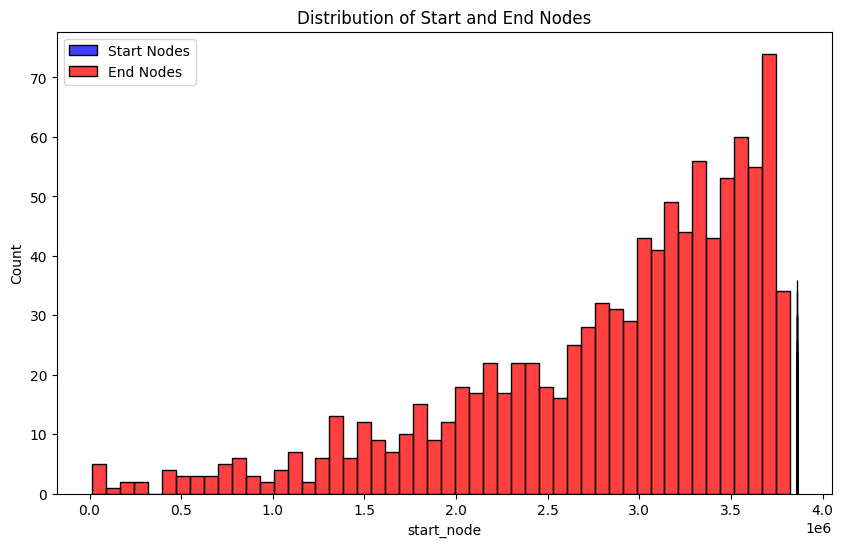

In [0]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load the dataset

# Descriptive analysis
print(data.info())
print(data.describe())
print(data.head())
print(data.isnull().sum())

plt.figure(figsize=(10, 6))
sns.histplot(data['start_node'], kde=False, bins=50, color='blue', label='Start Nodes')
sns.histplot(data['end_node'], kde=False, bins=50, color='red', label='End Nodes')
plt.title('Distribution of Start and End Nodes')
plt.legend()
plt.show()



In [0]:
 # Create a graph from the data
G = nx.from_pandas_edgelist(data, 'start_node', 'end_node')
print(nx.info(G))

# Generate walks and train the Node2Vec model
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=1)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
model.wv.save_word2vec_format('patent_embeddings.emb')


Graph with 1196 nodes and 1000 edges


/root/.ipykernel/5130/command-3811081234880219-1896411396:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


Computing transition probabilities:   0%|          | 0/1196 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:24<00:00,  8.11it/s]


Recommendations for patent 3858241: [1324234, 3634889, 3398406, 3557384, 3705312]


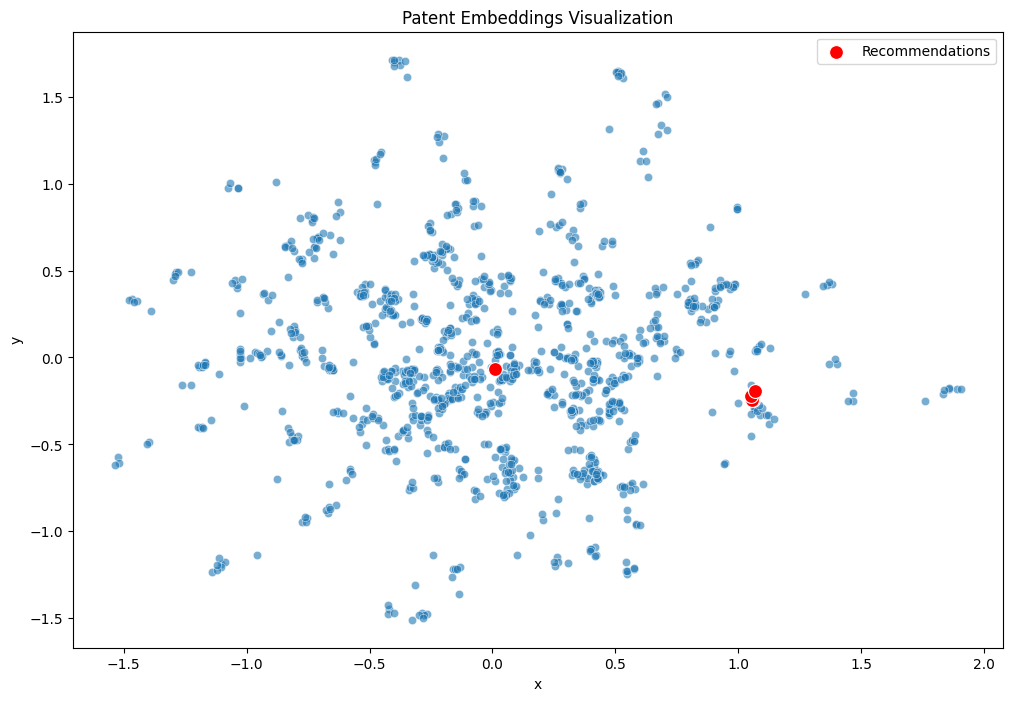

In [0]:

# Function to get recommendations for a given node
def get_recommendations(node, top_n=5):
    try:
        similar_nodes = model.wv.most_similar(str(node), topn=top_n)
        return [int(node[0]) for node in similar_nodes]
    except KeyError:
        return []

# Example: Get recommendations for a specific patent
patent_id = 3858241
recommendations = get_recommendations(patent_id)
print(f"Recommendations for patent {patent_id}: {recommendations}")

# Get embeddings for visualization
embeddings = model.wv.vectors
nodes = model.wv.index_to_key

# Reduce dimensions for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Create a DataFrame for visualization
df_embeddings = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df_embeddings['node'] = nodes

# Plot the embeddings
plt.figure(figsize=(12, 8))
sns.scatterplot(x='x', y='y', data=df_embeddings, alpha=0.6)

# Highlight the recommendations
if recommendations:
    rec_indices = [nodes.index(str(node)) for node in recommendations if str(node) in nodes]
    sns.scatterplot(x=df_embeddings.loc[rec_indices, 'x'], y=df_embeddings.loc[rec_indices, 'y'], color='red', s=100, label='Recommendations')

plt.title('Patent Embeddings Visualization')
plt.legend()
plt.show()
